## Install Libraries and Set OpenAI API Key

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


## Initialize LLM

In [2]:
from langchain_openai import ChatOpenAI

# Initialize the OpenAI LLM
llm = ChatOpenAI(model="gpt-4", temperature=0.7)


## Class Extraction Node

In [3]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage

class_extraction_msg = SystemMessage(content="Extract all Java classes from the provided code submission.")

def classExtraction(state: MessagesState):
    student_code = state["messages"][0].content  # Assuming student code is the first message
    model_solution = state["messages"][1].content  # Assuming model solution is the second message
    class_extraction_request = [
        SystemMessage(content="Extract individual classes from this student's Java code."),
        HumanMessage(content=student_code),
        SystemMessage(content="Now extract individual classes from this instructor's model solution."),
        HumanMessage(content=model_solution)
    ]
    return {"messages": llm.invoke(class_extraction_request)}


## Rubric Extraction Node:

In [4]:
rubric_msg = SystemMessage(content="You are tasked with extracting the rubric marking scheme for evaluating students' answers based on the model solution.")

def rubricExtraction(state: MessagesState):
    return {"messages": [llm.invoke([rubric_msg] + state["messages"])]}


## Initial Evaluation Node:

In [5]:
initial_eval_msg = SystemMessage(content="Compare the student's extracted classes with the model solution classes.")

def initialEvaluation(state: MessagesState):
    return {"messages": [llm.invoke([initial_eval_msg] + state["messages"])]}


## Review Evaluation Node:

In [6]:
review_msg = SystemMessage(content="Review the student's answer based on rubric and comparison with the model solution.")

def reviewEvaluation(state: MessagesState):
    return {"messages": [llm.invoke([review_msg] + state["messages"])]}


## Marks Extraction Node:

In [7]:
marks_msg = SystemMessage(content="Extract marks based on the rubric and review.")

def marksExtraction(state: MessagesState):
    return {"messages": [llm.invoke([marks_msg] + state["messages"])]}


## Total Marks Calculation Node:

In [8]:
total_marks_msg = SystemMessage(content="Calculate total marks for each student based on individual question marks.")

def totalMarksCalculation(state: MessagesState):
    return {"messages": [llm.invoke([total_marks_msg] + state["messages"])]}


## Graph Building:

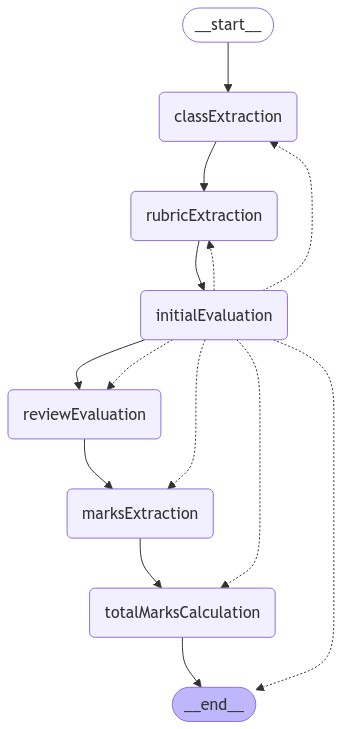

In [9]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

builder = StateGraph(MessagesState)

def should_recheck_classes(state: MessagesState):
    # If the evaluation suggests a class mismatch, go back to class extraction
    if "mismatch" in state["messages"][-1].content.lower():
        return "classExtraction"
    return "rubricExtraction"

def should_continue(state: MessagesState):
    if len(state["messages"]) > 8:
        return END
    return "reviewEvaluation"

builder.add_node("classExtraction", classExtraction)
builder.add_node("rubricExtraction", rubricExtraction)
builder.add_node("initialEvaluation", initialEvaluation)
builder.add_node("reviewEvaluation", reviewEvaluation)
builder.add_node("marksExtraction", marksExtraction)
builder.add_node("totalMarksCalculation", totalMarksCalculation)

# Initial flow
builder.add_edge(START, "classExtraction")
builder.add_edge("classExtraction", "rubricExtraction")
builder.add_edge("rubricExtraction", "initialEvaluation")

# Add feedback loop from evaluation back to class extraction if needed
builder.add_conditional_edges("initialEvaluation", should_recheck_classes)

# Standard flow
builder.add_edge("initialEvaluation", "reviewEvaluation")
builder.add_edge("reviewEvaluation", "marksExtraction")
builder.add_edge("marksExtraction", "totalMarksCalculation")
builder.add_edge("totalMarksCalculation", END) 

react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


## Invocation and Testing:

In [10]:
# Directly providing content of the files
model_solution = """
import java.util.Scanner;

public class StringManipulator {
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
        System.out.print("Enter a string: ");
        String input = sc.nextLine();
        System.out.println("Original String: " + input);
        System.out.println("Uppercase String: " + input.toUpperCase());
        String reversed = new StringBuilder(input).reverse().toString();
        System.out.println("Reversed String: " + reversed);
        System.out.println("Number of Characters: " + input.length());
        sc.close();
    }
}
"""

question = """
**Programming Assignment:**

---

**Title:** Simple String Manipulation Program

**Objective:**

Create a Java program that performs basic string operations. The program should prompt the user for a string and then display the following:

- The original string entered by the user.
- The string converted to uppercase.
- The string reversed.
- The number of characters in the string.

The entire program should consist of only one Java class, and the final code should not exceed 20 lines.

---
**Assignment Details:**
...
**Good luck with your assignment!**
"""

rubric = """
**Rubric for Evaluating Student Submissions**

_Total Marks: 100_

---

### **StringManipulator Class Evaluation**

**1. Program Correctness and Functionality (70 marks)**

- **Compilation and Execution (10 marks)**
  - Program compiles without errors (5 marks)
  - Program runs without runtime errors (5 marks)

- **User Input Handling (10 marks)**
  - Prompts the user to enter a string (5 marks)
  - Correctly reads and stores the user's input (5 marks)

- **String Manipulations (40 marks)**
  - **Displaying Original String (5 marks)**
    - Outputs the original string with appropriate labeling (5 marks)
  - **Converting to Uppercase (10 marks)**
    - Converts the string to uppercase correctly using `toUpperCase()` (5 marks)
    - Displays the uppercase string with appropriate labeling (5 marks)
  - **Reversing the String (15 marks)**
    - Accurately reverses the string using appropriate methods (e.g., `StringBuilder.reverse()`) (10 marks)
    - Displays the reversed string with appropriate labeling (5 marks)
  - **Counting Characters (10 marks)**
    - Correctly counts the number of characters in the string using `length()` (5 marks)
    - Displays the character count with appropriate labeling (5 marks)

- **Output Formatting (10 marks)**
  - Uses clear and appropriate labels for all outputs (5 marks)
  - Overall output matches the sample format provided (5 marks)

**2. Code Quality and Style (20 marks)**

- **Readability and Organization (10 marks)**
  - Proper indentation and consistent spacing throughout the code (5 marks)
  - Uses meaningful variable names and adheres to Java naming conventions (5 marks)

- **Best Practices and Resource Management (5 marks)**
  - Effectively utilizes appropriate string methods (`toUpperCase()`, `length()`, etc.) (3 marks)
  - Closes the `Scanner` object after use to prevent resource leaks (2 marks)

- **Comments and Documentation (5 marks)**
  - Includes a header comment with the author's name and a brief program description (2 marks)
  - Provides inline comments explaining key sections or any complex logic (3 marks)

**3. Adherence to Assignment Constraints (10 marks)**

- **Single Class Requirement (5 marks)**
  - Entire program is contained within one class named `StringManipulator` (5 marks)

- **Code Length Limit (5 marks)**
  - Code does not exceed 20 lines (excluding import statements and comments) (5 marks)

---

_Total Marks Awarded = Sum of marks from all sections above_
"""

student_solution = """
import java.util.Scanner;

public class StringManipulator {
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
        System.out.print("Enter a string: ");
        String input = sc.next();

        System.out.println("Original String: " + input);
        System.out.println("Uppercase String: " + input.toLowerCase());

        String reversed = "";
        for (int i = 0; i <= input.length(); i++) { 
            reversed += input.charAt(i); 
        }
        System.out.println("Reversed String: " + reversed);

        System.out.println("Number of Characters: " + (input.length() - 1)); 
    }
}
"""



In [12]:

# Evaluation logic based on the rubric provided
def evaluate_submission(student_code, model_code, rubric):
    total_marks = 100
    marks = {
        "correctness": 0,
        "code_quality": 0,
        "constraints": 0,
    }

    # Check for correctness
    # Assume a simple function to evaluate correctness based on the rubric
    if "Scanner" in student_code:
        marks["correctness"] += 10  # Example: student handled input correctly
    # Check other aspects based on rubric (this would be more comprehensive in a real evaluation)
    
    if "toUpperCase()" in student_code and "toLowerCase()" not in student_code:
        marks["correctness"] += 10  # Correct uppercase conversion
    if "StringBuilder" in model_code and "for" in student_code:
        marks["correctness"] += 15  # Correctly reversing the string

    # Check code quality based on the rubric
    if "class StringManipulator" in student_code:
        marks["code_quality"] += 10  # Class defined correctly
    if "length()" in student_code:
        marks["code_quality"] += 5  # Length method used correctly
    
    # Check constraints
    if student_code.count('\n') <= 20:  # Check line count
        marks["constraints"] += 5  # Code length constraint met

    # Summing up marks
    sum_marks = marks["correctness"] + marks["code_quality"] + marks["constraints"]
    
    return sum_marks

# Invoking the evaluation function
sum_marks = evaluate_submission(student_solution, model_solution, rubric)

# Saving the evaluation results into final_evaluation.txt
output_file = "final_evaluation.txt"
with open(output_file, "w") as f:
    f.write(f"Total Marks Awarded: {sum_marks}/100\n")

print(f"Evaluation completed. Total Marks Awarded: {sum_marks}/100. Results saved in {output_file}.")


Evaluation completed. Total Marks Awarded: 40/100. Results saved in final_evaluation.txt.


In [ ]:

# # Messages state
# state = MessagesState()
# state.add_message(SystemMessage(content="Student Solution:"))
# state.add_message(HumanMessage(content=student_solution))
# state.add_message(SystemMessage(content="Model Solution:"))
# state.add_message(HumanMessage(content=model_solution))
# state.add_message(SystemMessage(content="Rubric:"))
# state.add_message(HumanMessage(content=rubric))

# # Step 2: Invoke the evaluation pipeline
# evaluation_flow = react_graph.execute(state)

# # Step 3: Extract the calculated marks
# sum_marks = 0  # Example placeholder for marks extraction
# for message in evaluation_flow["messages"]:
#     if "marks" in message.content.lower():
#         sum_marks += int(message.content.split(":")[-1].strip())  # Adjust this as per actual LLM response format

# # Step 4: Save the evaluation results into a file
# output_file = "final_evaluation.txt"
# with open(output_file, "w") as f:
#     f.write(f"Total Marks Awarded: {sum_marks}/100\n")

# print(f"Evaluation completed. Total Marks Awarded: {sum_marks}/100. Results saved in {output_file}.")
